# House Prices - Advanced Regression Techniques (Kaggle)

Run after following notebooks are run:
1. 01 Data Cleaning
2. 02 Exploratory Data Analysis

#### Development Ideas
*  Need to scale discrete numerical variables as well

In [50]:
### set up libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
import seaborn as sns

pd.options.display.max_rows = 100

## Load Data

In [5]:
### load data (cleaned)
train = pd.read_csv('train_clean_truncated.csv')

### convert all object datatypes to category
for col in train.select_dtypes(include='object'):
    train[col] = train[col].astype('category')

### convert additional columns to category datatype
train['MSSubClass'] = train['MSSubClass'].astype('category')

train.shape

(1460, 67)

In [6]:
## separate in to predictor and response tables (x and y)
x_train = train.drop('SalePrice', axis=1)
y_train = train.SalePrice

## One Hot Encoding

In [7]:
x_train_onehot = pd.get_dummies(x_train, drop_first=True)
print(x_train_onehot.shape)
x_train_onehot.columns.to_list()

(1460, 201)


['LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'GrLivArea',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 'MoSold',
 'YrSold',
 'age_sold',
 'age_remodel_sold',
 'age_garage_sold',
 'bsmt_bath',
 'bath',
 'MSSubClass_30',
 'MSSubClass_40',
 'MSSubClass_45',
 'MSSubClass_50',
 'MSSubClass_60',
 'MSSubClass_70',
 'MSSubClass_75',
 'MSSubClass_80',
 'MSSubClass_85',
 'MSSubClass_90',
 'MSSubClass_120',
 'MSSubClass_160',
 'MSSubClass_180',
 'MSSubClass_190',
 'MSZoning_FV',
 'MSZoning_RH',
 'MSZoning_RL',
 'MSZoning_RM',
 'Alley_Pave',
 'LotShape_Reg',
 'LandContour_HLS',
 'LandContour_Low',
 'LandContour_Lvl',
 'LotConfig_CulDSac',
 'LotConfig_FR',
 'LotConfig_Inside',
 'LandSlope_MOrS',
 'Neighborhood_Blueste',
 'Neighborhood_BrDale',
 'Neighborhood_BrkSide',
 'Neighborhood_C

## Modelling - Cross-Validation and Optimisation

### Random Forest

{'n_estimators': 200}


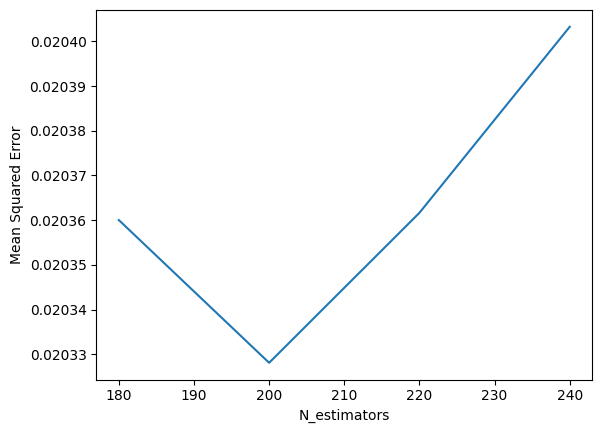

In [128]:
## hyperparameter tuning: n_estimators
param_grid = {'n_estimators' : np.arange(180,250,20)}
kf = KFold(n_splits=6, shuffle=True, random_state=8)

rf_tuning = GridSearchCV(RandomForestRegressor(random_state=8), param_grid, scoring='neg_mean_squared_error', cv=kf)
rf_tuning.fit(x_train_onehot.values, y_train.values)
rf_tuning_params = rf_tuning.cv_results_['param_n_estimators']
rf_tuning_mse = -rf_tuning.cv_results_['mean_test_score']

## find best param with lowest mse, and plot params against mse
print(rf_tuning.best_params_)
plt.plot(rf_tuning_params, rf_tuning_mse)
plt.xlabel('N_estimators')
plt.ylabel('Mean Squared Error')
None

In [132]:
## instantiate rf algorithm, using best tuned param
rf = RandomForestRegressor(n_estimators=200)

## cross validation
kf = KFold(n_splits=6, shuffle=True, random_state=8)
rf_cv_scores = cross_val_score(rf, x_train_onehot.values, y_train.values, scoring='neg_mean_squared_error', cv=kf)
print(f'avg MSE: {-np.mean(rf_cv_scores)}\n', f'splits MSE: {-rf_cv_scores}')

avg MSE: 0.020245282488916886
 splits MSE: [0.01659602 0.02017911 0.02838797 0.01719779 0.02163125 0.01747956]


In [175]:
## List feature importance
rf.fit(x_train_onehot.values, y_train.values)
rf_ft_imp = pd.DataFrame(data={'Features': x_train_onehot.columns, 'Gini Importance':rf.feature_importances_*100})
rf_ft_imp.sort_values(by='Gini Importance', ascending=False).head(15)

,Features,Gini Importance
2,OverallQual,55.298085
11,GrLivArea,10.821649
8,TotalBsmtSF,4.819945
16,GarageCars,3.860371
17,GarageArea,2.696143
9,1stFlrSF,2.580689
5,BsmtFinSF1,2.239145
166,CentralAir_Y,1.507482
1,LotArea,1.264876
3,OverallCond,1.163024


### KNN

{'n_neighbors': 6}


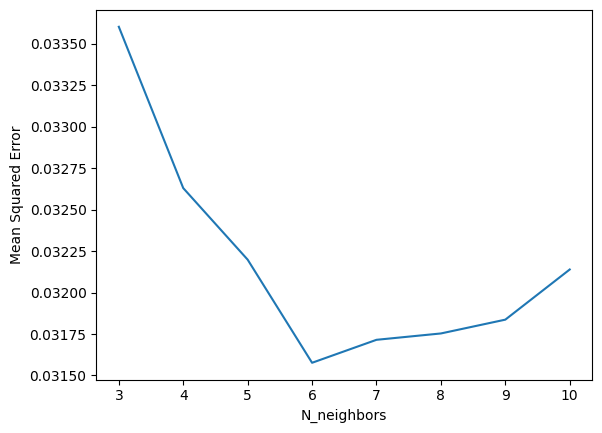

In [173]:
## limit x vars to top 10 by gini importance (determined in rf section)
top10_vars = rf_ft_imp.sort_values(by='Gini Importance', ascending=False).head(10)['Features'].to_list()
x_train_onehot_top10 = x_train_onehot[top10_vars]

## hyperparameter tuning: alpha
param_grid = {'n_neighbors' : np.arange(3,11)}
kf = KFold(n_splits=6, shuffle=True, random_state=8)

knn_tuning = GridSearchCV(KNeighborsRegressor(weights='distance'), param_grid, scoring='neg_mean_squared_error', cv=kf)
knn_tuning.fit(x_train_onehot_top10.values, y_train.values)
knn_tuning_params = knn_tuning.cv_results_['param_n_neighbors']
knn_tuning_mse = -knn_tuning.cv_results_['mean_test_score']

## find best param with lowest mse, and plot params against mse
print(knn_tuning.best_params_)
plt.plot(knn_tuning_params, knn_tuning_mse)
plt.xlabel('N_neighbors')
plt.ylabel('Mean Squared Error')
None

In [174]:
## instantiate knn algorithm, using best tuned param
knn = KNeighborsRegressor(n_neighbors=6, weights='distance')

## cross validation
kf = KFold(n_splits=6, shuffle=True, random_state=8)
knn_cv_scores = cross_val_score(knn, x_train_onehot_top10.values, y_train.values, scoring='neg_mean_squared_error', cv=kf)
print(f'avg MSE: {-np.mean(knn_cv_scores)}\n', f'splits MSE: {-knn_cv_scores}')

avg MSE: 0.031576323236047726
 splits MSE: [0.02890515 0.02872285 0.0410684  0.03035879 0.03362465 0.0267781 ]


### Lasso

{'alpha': 0.00015000000000000001}


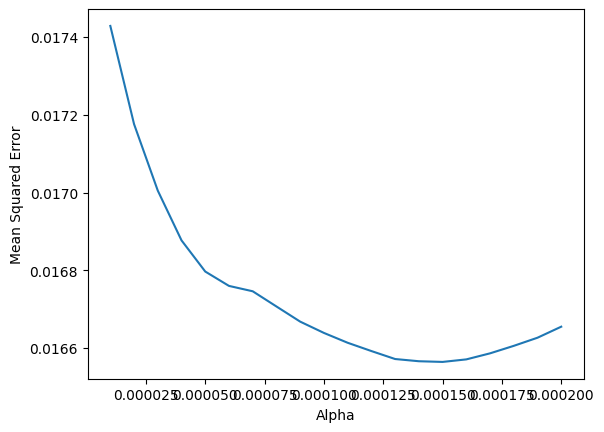

In [121]:
## hyperparameter tuning: alpha
param_grid = {'alpha': np.linspace(0.00001, 0.0002, 20)}
kf = KFold(n_splits=5, shuffle=True, random_state=8)

lasso_tuning = GridSearchCV(Lasso(random_state=8), param_grid, scoring='neg_mean_squared_error', cv=kf)
lasso_tuning.fit(x_train_onehot.values, y_train.values)
lasso_tuning_params = lasso_tuning.cv_results_['param_alpha']
lasso_tuning_mse = -lasso_tuning.cv_results_['mean_test_score']

## find best param with lowest mse, and plot params against mse
print(lasso_tuning.best_params_)
plt.plot(lasso_tuning_params, lasso_tuning_mse)
plt.xlabel('Alpha')
plt.ylabel('Mean Squared Error')
None

In [108]:
## instantiate rf algorith, using best tuned param
lasso = Lasso(alpha=0.00015)

## cross validation
kf = KFold(n_splits=5, shuffle=True, random_state=8)
lasso_cv_scores = cross_val_score(lasso, x_train_onehot.values, y_train.values, scoring='neg_mean_squared_error', cv=kf)
print(f'avg MSE: {np.mean(-lasso_cv_scores)}\n', f'splits MSE: {-lasso_cv_scores}')

avg MSE: 0.01656425142097109
 splits MSE: [0.01419711 0.01834571 0.01673173 0.01430104 0.01924567]
